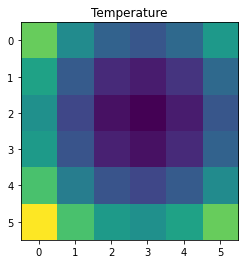

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

In [2]:
xres = (x[-1] - x[0]) / len(x)
xres

30.0

In [3]:
yres = (y[-1] - y[0]) / len(y)
yres

-30.0

In [4]:
from rasterio.transform import Affine
print(Affine.translation(x[0] - xres / 2, y[0] - yres / 2))

| 1.00, 0.00,-105.00|
| 0.00, 1.00, 105.00|
| 0.00, 0.00, 1.00|


In [5]:
print(Affine.scale(xres, yres))

| 30.00, 0.00, 0.00|
| 0.00,-30.00, 0.00|
| 0.00, 0.00, 1.00|


In [6]:
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)
print(transform)

| 30.00, 0.00,-105.00|
| 0.00,-30.00, 105.00|
| 0.00, 0.00, 1.00|


In [7]:
import rasterio
with rasterio.open(
    '../temp/Z.tif',
    'w',
    driver='GTiff',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(Z, 1)

In [8]:
print(transform*(0,0))

(-105.0, 105.0)


In [9]:
print(transform*(1,1))

(-75.0, 75.0)


In [10]:
print(transform*(5,2))

(45.0, 45.0)


In [11]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform

dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:

    # transform for input raster
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,    # source CRS
        dst_crs,    # destination CRS
        src.width,    # column count
        src.height,  # row count
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

print("Source Transform:\n",src_transform,'\n')
print("Destination Transform:\n", dst_transform)

Source Transform:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Destination Transform:
 | 33.24, 0.00,-6105300.09|
| 0.00,-33.24,-2885952.71|
| 0.00, 0.00, 1.00|


In [12]:
dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    with rasterio.open("../temp/LC08_20200518_webMC.tif", "w", **dst_kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )